In [ ]:
!unzip -j "/content/drive/MyDrive/train" -d "/content/train"

!unzip -j "/content/drive/MyDrive/test2" -d "/content/test2"

Archive:  /content/drive/MyDrive/train.zip
  inflating: /content/train/80.BMP   
  inflating: /content/train/79.BMP   
  inflating: /content/train/83.BMP   
  inflating: /content/train/99.BMP   
  inflating: /content/train/89.BMP   
  inflating: /content/train/97.BMP   
  inflating: /content/train/96.BMP   
  inflating: /content/train/98.BMP   
  inflating: /content/train/72.BMP   
  inflating: /content/train/94.BMP   
  inflating: /content/train/90.BMP   
  inflating: /content/train/86.BMP   
  inflating: /content/train/93.BMP   
  inflating: /content/train/85.BMP   
  inflating: /content/train/87.BMP   
  inflating: /content/train/95.BMP   
  inflating: /content/train/82.BMP   
  inflating: /content/train/77.BMP   
  inflating: /content/train/9.BMP    
  inflating: /content/train/7.BMP    
  inflating: /content/train/8.BMP    
  inflating: /content/train/84.BMP   
  inflating: /content/train/73.BMP   
  inflating: /content/train/71.BMP   
  inflating: /content/train/70.BMP   
  infla

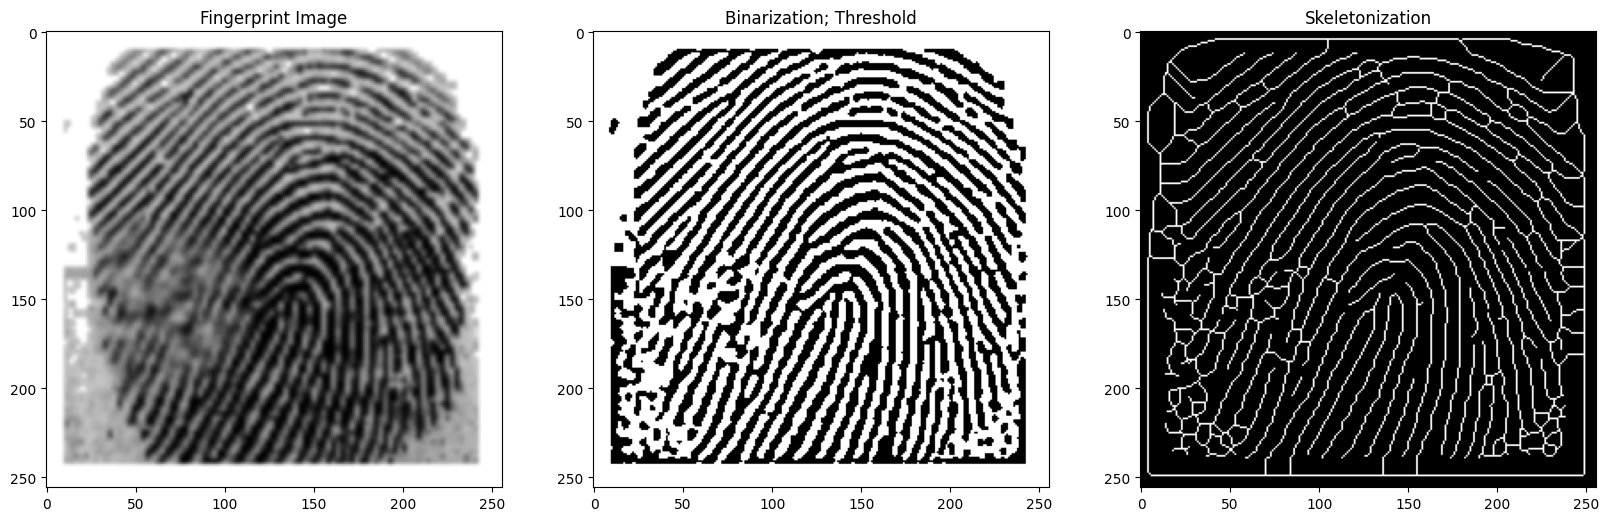

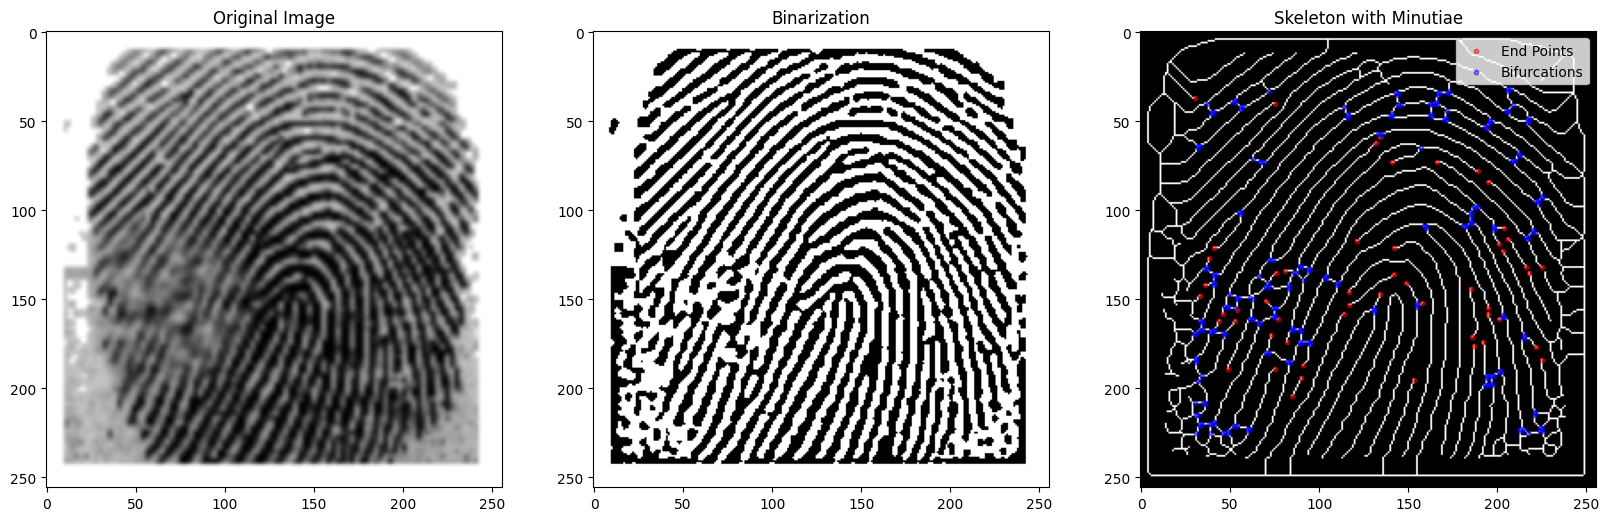

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects

def preprocess_image(image_path):
    # 이미지 읽기
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 히스토그램 평활화 적용
    img = cv2.equalizeHist(img)

    # Gaussian Blur 적용
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # 적응형 이진화 적용
    binary_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # 이진화된 이미지를 0과 1로 변환
    binary_img = binary_img // 255

    # 작은 노이즈 제거
    binary_img = remove_small_objects(binary_img.astype(bool), min_size=50, connectivity=2).astype(int)

    # 세선화
    skeleton = skeletonize(binary_img)

    return img, binary_img, skeleton

def visualize_preprocessing(image_path):
    original, binary, skeleton = preprocess_image(image_path)

    # 시각화
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))

    ax[0].imshow(original, cmap='gray')
    ax[0].set_title('Fingerprint Image')

    ax[1].imshow(binary, cmap='gray')
    ax[1].set_title('Binarization; Threshold')

    ax[2].imshow(skeleton, cmap='gray')
    ax[2].set_title('Skeletonization')

    plt.show()

# 전처리 과정 시각화
image_path = '/content/test2/100_type2.BMP'  # 실제 파일 경로로 변경
visualize_preprocessing(image_path)

def extract_minutiae(skeleton):
    minutiae_end = np.zeros(skeleton.shape, dtype=np.uint8)
    minutiae_bif = np.zeros(skeleton.shape, dtype=np.uint8)

    # 3x3 윈도우를 순회하며 끝점과 분기점을 검출
    for i in range(1, skeleton.shape[0] - 1):
        for j in range(1, skeleton.shape[1] - 1):
            window = skeleton[i-1:i+2, j-1:j+2]
            center = window[1, 1]
            if center == 1:
                neighbors = np.sum(window) - center
                if neighbors == 1:
                    minutiae_end[i, j] = 1
                elif neighbors == 3:
                    minutiae_bif[i, j] = 1

    # 이미지 가장자리 부분 제거
    border = 30  # 가장자리에서 30 픽셀을 제외
    minutiae_end[:border, :] = 0
    minutiae_end[-border:, :] = 0
    minutiae_end[:, :border] = 0
    minutiae_end[:, -border:] = 0

    minutiae_bif[:border, :] = 0
    minutiae_bif[-border:, :] = 0
    minutiae_bif[:, :border] = 0
    minutiae_bif[:, -border:] = 0

    # 추가적인 노이즈 필터링
    mask = np.zeros_like(skeleton)
    mask[border:-border, border:-border] = 1

    minutiae_end = minutiae_end * mask
    minutiae_bif = minutiae_bif * mask

    return minutiae_end, minutiae_bif

def visualize_minutiae(image_path):
    original, binary, skeleton = preprocess_image(image_path)
    minutiae_end, minutiae_bif = extract_minutiae(skeleton)

    # 시각화
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))

    ax[0].imshow(original, cmap='gray')
    ax[0].set_title('Original Image')

    ax[1].imshow(binary, cmap='gray')
    ax[1].set_title('Binarization')

    ax[2].imshow(skeleton, cmap='gray')
    ax[2].set_title('Skeleton with Minutiae')

    # Minutiae 강조
    ax[2].scatter(np.where(minutiae_end)[1], np.where(minutiae_end)[0], c='red', s=10, alpha=0.5, label='End Points')
    ax[2].scatter(np.where(minutiae_bif)[1], np.where(minutiae_bif)[0], c='blue', s=10, alpha=0.5, label='Bifurcations')
    ax[2].legend()

    plt.show()

# 예시: 한 장의 이미지에 대해 전처리, 특징 추출 및 시각화
visualize_minutiae(image_path)


In [ ]:
import cv2
import numpy as np
import os
import time
from skimage.morphology import skeletonize, remove_small_objects

def preprocess_image(image_path):
    # 이미지 읽기
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"이미지를 읽을 수 없습니다: {image_path}")

    # 히스토그램 평활화 적용
    img = cv2.equalizeHist(img)

    # Gaussian Blur 적용
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # 적응형 이진화 적용
    binary_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # 이진화된 이미지를 0과 1로 변환
    binary_img = binary_img // 255

    # 작은 노이즈 제거
    binary_img = remove_small_objects(binary_img.astype(bool), min_size=50, connectivity=2).astype(int)

    # 세선화
    skeleton = skeletonize(binary_img)

    return img, binary_img, skeleton

def extract_minutiae(skeleton):
    minutiae_end = np.zeros(skeleton.shape, dtype=np.uint8)
    minutiae_bif = np.zeros(skeleton.shape, dtype=np.uint8)

    # 3x3 윈도우를 순회하며 끝점과 분기점을 검출
    for i in range(1, skeleton.shape[0] - 1):
        for j in range(1, skeleton.shape[1] - 1):
            window = skeleton[i-1:i+2, j-1:j+2]
            center = window[1, 1]
            if center == 1:
                neighbors = np.sum(window) - center
                if neighbors == 1:
                    minutiae_end[i, j] = 1
                elif neighbors == 3:
                    minutiae_bif[i, j] = 1

    # 이미지 가장자리 부분 제거
    border = 30  # 가장자리에서 30 픽셀을 제외
    minutiae_end[:border, :] = 0
    minutiae_end[-border:, :] = 0
    minutiae_end[:, :border] = 0
    minutiae_end[:, -border:] = 0

    minutiae_bif[:border, :] = 0
    minutiae_bif[-border:, :] = 0
    minutiae_bif[:, :border] = 0
    minutiae_bif[:, -border:] = 0

    # 추가적인 노이즈 필터링
    mask = np.zeros_like(skeleton)
    mask[border:-border, border:-border] = 1

    minutiae_end = minutiae_end * mask
    minutiae_bif = minutiae_bif * mask

    return minutiae_end, minutiae_bif

# 전체 실행 시간 측정
start_time = time.time()

# 디렉토리 설정
train_dir = '/content/train'
test_dir = '/content/test2'

# Train 디렉토리의 모든 이미지를 전처리하고 특징점 추출
train_minutiae_list = []
for train_image_name in os.listdir(train_dir):
    if train_image_name.endswith(('.BMP', '.bmp' )):
        train_image_path = os.path.join(train_dir, train_image_name)
        if os.path.isfile(train_image_path):
            try:
                original_train, binary_train, skeleton_train = preprocess_image(train_image_path)
                minutiae_end_train, minutiae_bif_train = extract_minutiae(skeleton_train)
                train_minutiae = np.column_stack(np.where(minutiae_end_train + minutiae_bif_train))
                train_minutiae_list.append((train_image_name, train_minutiae))
            except Exception as e:
                print(e)

# Test 디렉토리의 모든 이미지를 전처리하고 특징점 추출
test_minutiae_list = []
for test_image_name in os.listdir(test_dir):
    if test_image_name.endswith(('.BMP', '.bmp')):
        test_image_path = os.path.join(test_dir, test_image_name)
        if os.path.isfile(test_image_path):
            try:
                original_test, binary_test, skeleton_test = preprocess_image(test_image_path)
                minutiae_end_test, minutiae_bif_test = extract_minutiae(skeleton_test)
                test_minutiae = np.column_stack(np.where(minutiae_end_test + minutiae_bif_test))
                test_minutiae_list.append((test_image_name, test_minutiae))
            except Exception as e:
                print(e)

# 전체 실행 시간 출력
end_time = time.time()
print(f"전처리 및 특징 추출 전체 실행 시간: {end_time - start_time:.4f} 초")


전처리 및 특징 추출 전체 실행 시간: 403.3514 초


In [ ]:
import cv2
import numpy as np
import os
import time
from skimage.morphology import skeletonize, remove_small_objects
from numba import jit, prange

def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} 실행 시간: {end_time - start_time:.4f} 초")
        return result
    return wrapper

@measure_time
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"이미지를 읽을 수 없습니다: {image_path}")
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_img = binary_img // 255
    binary_img = remove_small_objects(binary_img.astype(bool), min_size=50, connectivity=2).astype(int)
    skeleton = skeletonize(binary_img)
    return img, binary_img, skeleton

@measure_time
@jit(nopython=True, parallel=True)
def extract_minutiae_optimized(skeleton):
    rows, cols = skeleton.shape
    minutiae_end = np.zeros(skeleton.shape, dtype=np.uint8)
    minutiae_bif = np.zeros(skeleton.shape, dtype=np.uint8)

    for i in prange(1, rows - 1):
        for j in prange(1, cols - 1):
            if skeleton[i, j] == 1:
                neighbors = (skeleton[i-1, j-1] + skeleton[i-1, j] + skeleton[i-1, j+1] +
                             skeleton[i, j-1] + skeleton[i, j+1] +
                             skeleton[i+1, j-1] + skeleton[i+1, j] + skeleton[i+1, j+1])
                if neighbors == 1:
                    minutiae_end[i, j] = 1
                elif neighbors == 3:
                    minutiae_bif[i, j] = 1

    border = 30
    mask = np.ones_like(skeleton)
    mask[:border, :] = 0
    mask[-border:, :] = 0
    mask[:, :border] = 0
    mask[:, -border:] = 0

    minutiae_end *= mask
    minutiae_bif *= mask

    return minutiae_end, minutiae_bif

# 디렉토리 설정
train_dir = '/content/train'
test_dir = '/content/test2'

# 전체 실행 시간 측정
start_time = time.time()

# Train 디렉토리의 모든 이미지를 전처리하고 특징점 추출
train_minutiae_list = []
for train_image_name in os.listdir(train_dir):
    train_image_path = os.path.join(train_dir, train_image_name)
    if os.path.isfile(train_image_path):
        try:
            original_train, binary_train, skeleton_train = preprocess_image(train_image_path)
            minutiae_end_train, minutiae_bif_train = extract_minutiae_optimized(skeleton_train)
            train_minutiae = np.column_stack(np.where(minutiae_end_train + minutiae_bif_train))
            train_minutiae_list.append((train_image_name, train_minutiae))
        except Exception as e:
            print(e)

# Test 디렉토리의 모든 이미지를 전처리하고 특징점 추출
test_minutiae_list = []
for test_image_name in os.listdir(test_dir):
    test_image_path = os.path.join(test_dir, test_image_name)
    if os.path.isfile(test_image_path):
        try:
            original_test, binary_test, skeleton_test = preprocess_image(test_image_path)
            minutiae_end_test, minutiae_bif_test = extract_minutiae_optimized(skeleton_test)
            test_minutiae = np.column_stack(np.where(minutiae_end_test + minutiae_bif_test))
            test_minutiae_list.append((test_image_name, test_minutiae))
        except Exception as e:
            print(e)

# 전체 실행 시간 출력
end_time = time.time()
print(f"전처리 및 특징 추출 전체 실행 시간: {end_time - start_time:.4f} 초")


preprocess_image 실행 시간: 0.0110 초
extract_minutiae_optimized 실행 시간: 4.0514 초
preprocess_image 실행 시간: 0.0076 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0084 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0096 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0082 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0081 초
extract_minutiae_optimized 실행 시간: 0.0007 초
preprocess_image 실행 시간: 0.0075 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0080 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0083 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0084 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0075 초
extract_minutiae_optimized 실행 시간: 0.0008 초
preprocess_image 실행 시간: 0.0097 초
extract_minutiae_optimized 실행 시간: 0.0009 초
preprocess_image 실행 시간: 0.0079 초
extract_minutiae_optimized 실행 시간: 0.0009 초
preprocess_i

In [12]:
import cv2
import numpy as np
import os
from skimage.morphology import skeletonize, remove_small_objects
from skimage import measure
from numba import jit, prange
import json

# 이미지 전처리 함수
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"이미지를 읽을 수 없습니다: {image_path}")
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_img = binary_img // 255
    binary_img = remove_small_objects(binary_img.astype(bool), min_size=50, connectivity=2).astype(int)
    skeleton = skeletonize(binary_img)
    return img, binary_img, skeleton

# 최적화된 특징점 추출 함수
@jit(nopython=True, parallel=True)
def extract_minutiae_optimized(skeleton):
    rows, cols = skeleton.shape
    minutiae_end = np.zeros(skeleton.shape, dtype=np.uint8)
    minutiae_bif = np.zeros(skeleton.shape, dtype=np.uint8)

    for i in prange(1, rows - 1):
        for j in prange(1, cols - 1):
            if skeleton[i, j] == 1:
                neighbors = (skeleton[i-1, j-1] + skeleton[i-1, j] + skeleton[i-1, j+1] +
                             skeleton[i, j-1] + skeleton[i, j+1] +
                             skeleton[i+1, j-1] + skeleton[i+1, j] + skeleton[i+1, j+1])
                if neighbors == 1:
                    minutiae_end[i, j] = 1
                elif neighbors == 3:
                    minutiae_bif[i, j] = 1

    border = 30
    mask = np.ones_like(skeleton)
    mask[:border, :] = 0
    mask[-border:, :] = 0
    mask[:, :border] = 0
    mask[:, -border:] = 0

    minutiae_end *= mask
    minutiae_bif *= mask

    return minutiae_end, minutiae_bif

# 특징점 매칭 함수
def match_minutiae(test_minutiae, train_minutiae):
    if len(test_minutiae) == 0 or len(train_minutiae) == 0:
        return None, float('inf')

    distances = []
    for test_point in test_minutiae:
        min_distance = float('inf')
        for train_point in train_minutiae:
            distance = np.linalg.norm(test_point - train_point)
            if distance < min_distance:
                min_distance = distance
        distances.append(min_distance)

    mean_distance = np.mean(distances)
    return distances, mean_distance

# 디렉토리 설정
train_dir = '/content/train'
test_dir = '/content/test2'

# Train 이미지 전처리 및 특징점 추출
train_minutiae_list = []
for train_image_name in os.listdir(train_dir):
    train_image_path = os.path.join(train_dir, train_image_name)
    if os.path.isfile(train_image_path):
        try:
            _, _, skeleton_train = preprocess_image(train_image_path)
            minutiae_end_train, minutiae_bif_train = extract_minutiae_optimized(skeleton_train)
            train_minutiae = np.column_stack(np.where(minutiae_end_train + minutiae_bif_train))
            train_minutiae_list.append((train_image_name, train_minutiae))
        except Exception as e:
            print(e)

# Test 이미지 전처리 및 특징점 추출
test_minutiae_list = []
for test_image_name in os.listdir(test_dir):
    test_image_path = os.path.join(test_dir, test_image_name)
    if os.path.isfile(test_image_path) and test_image_name.lower().endswith(('.bmp')):
        try:
            _, _, skeleton_test = preprocess_image(test_image_path)
            minutiae_end_test, minutiae_bif_test = extract_minutiae_optimized(skeleton_test)
            test_minutiae = np.column_stack(np.where(minutiae_end_test + minutiae_bif_test))
            test_minutiae_list.append((test_image_name, test_minutiae))
        except Exception as e:
            print(e)

# 특징점 매칭
matches = {}
distances = {}
for test_name, test_minutiae in test_minutiae_list:
    best_match = None
    best_distance = float('inf')
    for train_name, train_minutiae in train_minutiae_list:
        _, distance = match_minutiae(test_minutiae, train_minutiae)
        if distance < best_distance:
            best_distance = distance
            best_match = train_name
    matches[test_name] = best_match
    distances[test_name] = best_distance
    print(f"Best match for {test_name}: {best_match} with distance {best_distance}")

# 매칭 결과와 거리 저장
with open('matches.json', 'w') as f:
    json.dump(matches, f)

with open('distances.json', 'w') as f:
    json.dump(distances, f)


Best match for 68_type3.BMP: 68.BMP with distance 0.8141821016485339
Best match for 138_type1.BMP: 138.BMP with distance 0.20715765717185683
Best match for 413_type3.BMP: 413.BMP with distance 0.0
Best match for 533_type3.BMP: 533.BMP with distance 3.0059866238401893
Best match for 283_type3.BMP: 597.BMP with distance 4.602312626553406
Best match for 420_type3.BMP: 420.BMP with distance 0.07362359855281135
Best match for 296_type1.BMP: 296.BMP with distance 0.8155300408906443
Best match for 464_type1.BMP: 464.BMP with distance 0.2746005023101146
Best match for 575_type2.BMP: 575.BMP with distance 2.0514262639753253
Best match for 266_type3.BMP: 266.BMP with distance 0.045454545454545456
Best match for 533_type1.BMP: 324.BMP with distance 8.731182947116665
Best match for 512_type1.BMP: 512.BMP with distance 2.751330833329676
Best match for 137_type1.BMP: 137.BMP with distance 0.0
Best match for 280_type1.BMP: 280.BMP with distance 0.0
Best match for 235_type3.BMP: 235.BMP with distance 

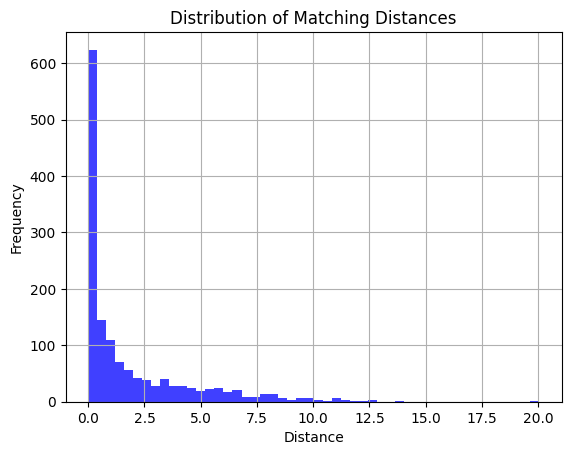

In [14]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 매칭 거리 불러오기
with open('/content/distances.json', 'r') as f:
    distances = json.load(f)

# 거리 값들 리스트로 변환
distance_values = list(distances.values())

# Infinite 값 제거
distance_values = [d for d in distance_values if np.isfinite(d)]

# 거리 값의 분포를 시각화
plt.hist(distance_values, bins=50, alpha=0.75, color='blue')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Matching Distances')
plt.grid(True)
plt.show()


In [16]:
import json
import os

# Load matching results and distances
with open('/content/matches.json', 'r') as f:
    matches = json.load(f)

with open('/content/distances.json', 'r') as f:
    distances = json.load(f)

# Set an appropriate threshold based on the distance distribution
threshold = 2.0

TP = 0  # True Positive
FP = 0  # False Positive
FN = 0  # False Negative
TN = 0  # True Negative

# Analyze matching results and distances
for test_name, train_name in matches.items():
    actual_name = os.path.basename(test_name).split('_')[0] + '.BMP'
    distance = distances[test_name]
    if distance <= threshold:
        if actual_name == train_name:
            TP += 1
        else:
            FP += 1
    else:
        if actual_name == train_name:
            FN += 1
        else:
            TN += 1

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
FAR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Acceptance Rate
FRR = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Rejection Rate

print(f"Threshold: {threshold}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"FAR: {FAR:.4f}")
print(f"FRR: {FRR:.4f}")


Threshold: 2.0
Precision: 0.9940
Recall: 0.8086
Accuracy: 0.8298
FAR: 0.0316
FRR: 0.1914


In [17]:
thresholds = [0.5, 1.0, 1.5, 2.0, 2.5]

for threshold in thresholds:
    TP = 0  # True Positive
    FP = 0  # False Positive
    FN = 0  # False Negative
    TN = 0  # True Negative

    # Analyze matching results and distances
    for test_name, train_name in matches.items():
        actual_name = os.path.basename(test_name).split('_')[0] + '.BMP'
        distance = distances[test_name]
        if distance <= threshold:
            if actual_name == train_name:
                TP += 1
            else:
                FP += 1
        else:
            if actual_name == train_name:
                FN += 1
            else:
                TN += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    FAR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Acceptance Rate
    FRR = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Rejection Rate

    print(f"Threshold: {threshold}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"FAR: {FAR:.4f}")
    print(f"FRR: {FRR:.4f}")
    print('---')


Threshold: 0.5
Precision: 0.9925
Recall: 0.5339
Accuracy: 0.5924
FAR: 0.0263
FRR: 0.4661
---
Threshold: 1.0
Precision: 0.9928
Recall: 0.6680
Accuracy: 0.7080
FAR: 0.0316
FRR: 0.3320
---
Threshold: 1.5
Precision: 0.9936
Recall: 0.7472
Accuracy: 0.7766
FAR: 0.0316
FRR: 0.2528
---
Threshold: 2.0
Precision: 0.9940
Recall: 0.8086
Accuracy: 0.8298
FAR: 0.0316
FRR: 0.1914
---
Threshold: 2.5
Precision: 0.9896
Recall: 0.8417
Accuracy: 0.8550
FAR: 0.0579
FRR: 0.1583
---
